## 模型训练

- 数据集切分按照疾病、种族进行

- 目前只针对蛋白组

- 分种族训练



### 预处理

In [123]:
from config import *
import pandas as pd
import json
from ppp_prediction.utils import load_data
from ppp_prediction.model import fit_best_model
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from ppp_prediction.plot.utils import save_fig

In [110]:
# Define Basic Variables

groupByVar = "Ethnic"  # Ethnic
omicsName = "Prot_meanImpute"  # used omics Name
phenoDefineVersion = "Lancet_Digital_Health_2019"  # used pheno version

## cutoff
Case_cutoff = 50  # only over this number of cases will be used as a phenotype

In [113]:
# Define the dirs
covariates_dir = dataDir / "covariates.feather"
omicsDataDir = dataDir / f"Prot/{omicsName}.feather"

phenoDefineDir = dataDir / f"{phenoDefineVersion}"

In [136]:
# load data
covariates_df = pd.read_feather(covariates_dir)
omicsData = pd.read_feather(omicsDataDir)
print(
    f"Total {omicsData.shape[0]} samples and {omicsData.shape[1]} features with {omicsName}"
)
diseaseList = list(phenoDefineDir.glob("*.feather"))
foundedPhenoFile = len(list(phenoDefineDir.glob("*.feather")))
print(f"Founded Pheno Files: {foundedPhenoFile}")
covariates_df

Total 53021 samples and 2912 features with Prot_meanImpute
Founded Pheno Files: 169


,eid,sex,height,weight,BSA,age,PC1,PC2,PC3,PC4,...,drug_ldl,drug_hdl,drug_tc,drug_sbp,drug_dbp,genotype_array,assessment_center,ancestry,ancestry_high_confi,Ethnic
0,1000017,1.0,172.0,89.5,2.067876,56.0,-11.3690,3.56718,-1.975530,0.213937,...,0.0,0.0,0.0,1.0,1.0,1,1,EUR,EUR,White
1,1000025,1.0,176.0,113.9,2.359755,62.0,-12.1620,2.77470,0.175048,2.554930,...,1.0,0.0,1.0,1.0,1.0,2,2,EUR,EUR,White
2,1000038,1.0,179.5,112.2,2.365252,60.0,-12.8698,6.41566,-5.106100,-1.296310,...,0.0,0.0,0.0,1.0,1.0,1,3,EUR,EUR,White
3,1000042,1.0,169.0,77.1,1.902476,60.0,72.9437,-109.21600,74.692200,17.863400,...,1.0,0.0,1.0,1.0,1.0,2,3,SAS,SAS,Asian
4,1000056,0.0,163.0,72.0,1.805547,65.0,-10.7174,5.77507,0.620341,0.505251,...,0.0,0.0,0.0,0.0,0.0,2,4,EUR,EUR,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502404,6024086,0.0,154.0,88.0,1.940218,66.0,-11.1845,4.08367,-0.006942,-0.325017,...,0.0,0.0,0.0,0.0,0.0,2,8,EUR,EUR,White
502405,6024098,1.0,173.0,81.3,1.976592,68.0,-13.3426,2.56658,-0.076882,6.048100,...,0.0,1.0,0.0,1.0,1.0,2,9,EUR,EUR,White
502406,6024103,1.0,187.0,111.3,2.404458,61.0,-12.2113,4.22902,-2.629170,4.489250,...,0.0,0.0,0.0,1.0,1.0,2,20,EUR,EUR,White
502407,6024110,1.0,177.0,73.2,1.897103,66.0,-10.5527,6.84118,-2.149580,-0.825010,...,0.0,0.0,0.0,0.0,0.0,2,11,EUR,EUR,White


In [137]:
# inner set
covariates_df = covariates_df.query("eid in @df.eid")

In [138]:
# groupByVar used
used_groupByVar = ["White", "Asian", "Black"]
covariates_df[groupByVar].value_counts()

Ethnic
White      49442
Black       1217
Asian        986
Other        879
Mixed        349
Chinese      148
Name: count, dtype: int64

In [125]:
# show all disease rate in Prot


res_dict = {
    "event": [],
    "incident": [],
    "prevalent": [],
}
for disease in tqdm(diseaseList, total=len(diseaseList), desc="Counting..."):
    df = pd.read_feather(disease).query("eid in @Prot_df.eid")

    for col in ["event", "incident", "prevalent"]:
        case = int(df[col].sum())
        control = int(df.shape[0] - case)
        rate = case / df.shape[0]
        res_dict[col].append(
            pd.DataFrame(
                {
                    "Phenotype": [disease.stem],
                    "Case": [case],
                    "Control": [control],
                    "Rate": [rate],
                }
            )
        )

Counting...: 100%|██████████| 169/169 [00:33<00:00,  5.00it/s]


In [126]:
event_df = (
    pd.concat(res_dict["event"])
    .sort_values("Rate", ascending=False)
    .reset_index(drop=True)
)
incident_df = (
    pd.concat(res_dict["incident"])
    .sort_values("Rate", ascending=False)
    .reset_index(drop=True)
)
prevalent_df = (
    pd.concat(res_dict["prevalent"])
    .sort_values("Rate", ascending=False)
    .reset_index(drop=True)
)

event_df

,Phenotype,Case,Control,Rate
0,hypertension,18096,34925,0.341299
1,oth_organisms,9692,43329,0.182795
2,bacterial,9516,43505,0.179476
3,cataract,7811,45210,0.147319
4,diverticuli,7732,45289,0.145829
...,...,...,...,...
164,sepsis_newborn,0,53021,0.000000
165,RDN,0,53021,0.000000
166,prematurity,0,53021,0.000000
167,HBW,0,53021,0.000000


(0.0, 0.2)

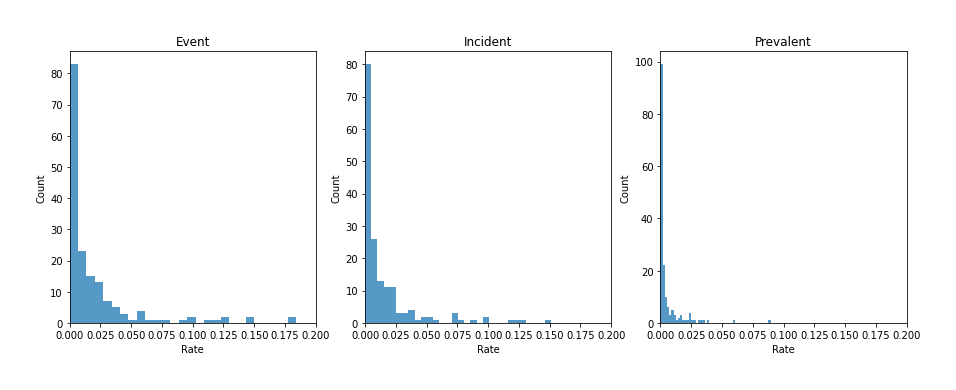

In [127]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# histplot
sns.histplot(data=event_df, x="Rate", ax=ax1, bins=50)
sns.histplot(data=incident_df, x="Rate", ax=ax2, bins=50)
sns.histplot(data=prevalent_df, x="Rate", ax=ax3, bins=50)

ax1.set_title("Event")
ax2.set_title("Incident")
ax3.set_title("Prevalent")

ax1.set_xlim(0, 0.2)
ax2.set_xlim(0, 0.2)
ax3.set_xlim(0, 0.2)

In [58]:
# event_df =
incident_df = incident_df.query("Case > @Case_cutoff")
prevalent_df = prevalent_df.query("Case > @Case_cutoff")

print(f"Finnal Incident Phenotype: {incident_df.shape[0]}")
print(f"Finnal Prevalent Phenotype: {prevalent_df.shape[0]}")

Finnal Incident Phenotype: 141
Finnal Prevalent Phenotype: 99


### Run Assoc

1. For prevalence, by Cox 
2. For incident, by logit

### 过滤表型

保存Case 至少>50的疾病

分种族过滤！

In [128]:
from ppp_prediction.model_v2.models import (
    fit_best_model_v2,
    fit_ensemble_model_simple_v2,
    fit_lightgbm,
    fit_xgboost,
)


def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [139]:
from sklearn.model_selection import train_test_split


# define a function to fit the model, save the result and collect the scores
## parallel this function
def fit_model_and_save_result(
    total_df,  # first col should be eid
    label_df,  # first col should be eid
    save_dir,
    # asssoc_df=None, # used to sort and get top features to downsample, if None then will do assoc
    feature_rank_list=None,  # used to downsample the features
    min_class_number_cutoff={"train": 30, "validation": 10, "test": 10},
    train_test_split_ratio=0.7,
    seed=1234,
    device="cuda",
):
    """
    1. merge the total_df and disease_df
    2. check label_df sum is over min_class_number_cutoff; if not return None, and print the error
    3. fit the models: 1) full lasso, 2) full xgboost, 3) sample lasso, 4) sample xgboost, 5) sample AutoTabPFN, 6) TabPFN
    4. save the results: 1) model, 2) scores of total_df, 3) metrics of models
    """
    # step1: merge and check

    ## check the first column
    if total_df.columns[0] != "eid":
        raise ValueError("total_df first column should be eid")
    if label_df.columns[0] != "eid":
        raise ValueError("label_df first column should be eid")

    features = total_df.columns[1:].tolist()
    label = label_df.columns[1]

    ## merge
    merged_df = pd.merge(total_df, label_df, on="eid", how="inner")
    print(
        f"Found merged samples: {merged_df.shape[0]} while, label_df: {label_df.shape[0]} and total_df: {total_df.shape[0]}"
    )

    # step2: fit the model
    ## step2.1 Train Test Split
    train_df, test_df = train_test_split(
        merged_df, test_size=1 - train_test_split_ratio, random_state=seed
    )
    train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=seed)

    score_df = pd.concat(
        [
            train_df[["eid"]].copy().assign(Type="train"),
            val_df[["eid"]].copy().assign(Type="validation"),
            test_df[["eid"]].copy().assign(Type="test"),
        ]
    )
    ## step2.2 check the min_class_number
    for min_class_number_check_key in ["train", "validation", "test"]:
        if min_class_number_check_key == "train":
            to_check_df = train_df
        elif min_class_number_check_key == "validation":
            to_check_df = val_df
        elif min_class_number_check_key == "test":
            to_check_df = test_df
        else:
            raise ValueError(
                "min_class_number_check_key should be in ['train', 'validation', 'test']"
            )
        min_class_number = min(to_check_df[label].value_counts())
        # the min class number and class name
        min_class_name = to_check_df[label].value_counts().idxmin()
        if min_class_number < min_class_number_cutoff[min_class_number_check_key]:
            print(
                f"Error: {min_class_number_check_key} {min_class_name} has only {min_class_number} samples, less than {min_class_number_cutoff[min_class_number_check_key]}"
            )
            return None
    print(
        f"Train data have {train_df.shape[0]} samples with {train_df[label].sum():.0f} cases"
    )
    print(
        f"Validation data have {val_df.shape[0]} samples with {val_df[label].sum():.0f} cases"
    )
    print(
        f"Test data have {test_df.shape[0]} samples with {test_df[label].sum():.0f} cases"
    )

    ## check

    ## step2.4 fit the models
    modelSaveDir = save_dir / "models"
    modelSaveDir.mkdir(parents=True, exist_ok=True)
    ### 1) Lasso full
    lasso_full_savedir = modelSaveDir / "lasso_full.pkl"
    if lasso_full_savedir.exists():
        lasso_full = pickle.load(open(lasso_full_savedir, "rb"))
        # print(f"lasso_full loaded")

    else:
        (lasso_full, *_) = fit_best_model(
            train_df=train_df,
            test_df=val_df,
            X_var=features,
            y_var=label,
            method_list="Lasso",
            cv=5,
            engine="cuml" if device == "cuda" else "sklearn",
        )

        pickle.dump(lasso_full, open(lasso_full_savedir, "wb"))

    score_df["lasso_full"] = get_predict_v2_from_df(lasso_full, total_df, features)
    return lasso_full, score_df
    del lasso_full

    # xgboost full
    xgboot_full_savedir = modelSaveDir / "xgboost_full.pkl"
    if (modelSaveDir / "xgboost_full.pkl").exists():
        print(f"xgboost_full loaded")
        xgboost_full_tuned = pickle.load(open(xgboot_full_savedir, "rb"))
    else:

        xgboost_full_tuned, *_ = fit_xgboost(
            train=train_df,
            xvar=features,
            label=label,
            tuning=True,
            tune_config={"max_iter": 100},
        )
        pickle.dump(xgboost_full_tuned, open(xgboot_full_savedir, "wb"))
    score_df["xgboost_full"] = get_predict_v2_from_df(
        xgboost_full_tuned, total_df, features
    )

    del xgboost_full_tuned

    for topk in [5, 10, 20, 50, 100]:
        sig_features = feature_rank_list[:topk]

        for strata in ["balance", "random"]:  # balance or random
            if strata == "balance":
                disease_train_case = train_df.query("label == 1")
                disease_train_control = train_df.query("label == 0").sample(
                    n=disease_train_case.shape[0], random_state=seed
                )
                disease_train_sample = pd.concat(
                    [disease_train_case, disease_train_control]
                )
            elif strata == "random":
                disease_train_sample = train_df.sample(
                    n=10000, random_state=seed
                )  # max 10000 samples
            suffix_name = f"{topk}_{strata}"

            print(suffix_name)

            strata_topk_save_dir = modelSaveDir / f"{topk}/{strata}"
            strata_topk_save_dir.mkdir(parents=True, exist_ok=True)

            X_train = disease_train_sample[sig_features]
            y_train = disease_train_sample[label]

            lasso_sample_topk_savedir = strata_topk_save_dir / f"lasso_sample.pkl"
            if lasso_sample_topk_savedir.exists():
                lasso_sample = pickle.load(open(lasso_sample_topk_savedir, "rb"))
                print(f"lasso_sample_{suffix_name} loaded")
            else:
                try:
                    (lasso_sample, *_) = fit_best_model(
                        train_df=disease_train_sample,
                        test_df=val_df,
                        X_var=sig_features,
                        y_var=label,
                        method_list="Lasso",
                        cv=3,
                        engine="cuml",
                    )
                    pickle.dump(
                        lasso_sample,
                        open(strata_topk_save_dir / f"lasso_sample.pkl", "wb"),
                    )
                except:
                    print(f"lasso_sample_{topk} failed")

            score_df[f"lasso_sample_{suffix_name}"] = get_predict_v2_from_df(
                lasso_sample, total_df, sig_features
            )

            del lasso_sample

            from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
                AutoTabPFNClassifier,
            )

            AutoTabPFN_topk_savedir = strata_topk_save_dir / f"AutoTabPFN.pkl"
            if AutoTabPFN_topk_savedir.exists():
                AutoTabPFN = pickle.load(open(AutoTabPFN_topk_savedir, "rb"))
                print(f"AutoTabPFN_{topk} loaded")
            else:

                try:
                    AutoTabPFN = AutoTabPFNClassifier(
                        max_time=120, device="cuda"
                    )  # 120 seconds tuning time
                    AutoTabPFN.fit(X_train, y_train)
                    pickle.dump(
                        AutoTabPFN, open(strata_topk_save_dir / f"AutoTabPFN.pkl", "wb")
                    )
                except:
                    print(f"AutoTabPFN_{topk} failed")

            # score_df["AutoTabPFN"] = AutoTabPFN.predict_proba(X_held_out_test)[:, 1]
            score_df[f"AutoTabPFN_{suffix_name}"] = AutoTabPFN.predict_proba(
                total_df[sig_features]
            )[:, 1]

            del AutoTabPFN
            try:
                from tabpfn import TabPFNClassifier

                TabPFN_topk_savedir = strata_topk_save_dir / f"TabPFN{topk}.pkl"
                if TabPFN_topk_savedir.exists():
                    TabPFN = pickle.load(open(TabPFN_topk_savedir, "rb"))
                    print(f"TabPFN_{topk} loaded")
                else:

                    TabPFN = TabPFNClassifier(
                        device="cuda:0", ignore_pretraining_limits=True
                    )
                    TabPFN.fit(X_train, y_train)
                    pickle.dump(
                        TabPFN, open(strata_topk_save_dir / f"TabPFN.pkl", "wb")
                    )
                # score_df["AutoTabPFN"] = AutoTabPFN.predict_proba(X_held_out_test)[:, 1]
                score_df[f"TabPFN_{suffix_name}"] = TabPFN.predict_proba(
                    total_df[sig_features]
                )[:, 1]

                del TabPFN
            except:
                print(f"TabPFN {topk} failed")

            # xgboost sampled
            xgboost_sample_savedir = strata_topk_save_dir / f"xgboost_sample.pkl"
            if xgboost_sample_savedir.exists():
                xgboost_sample_tuned = pickle.load(open(xgboost_sample_savedir, "rb"))
                print(f"xgboost_sample_{topk} loaded")
            else:
                try:
                    xgboost_sample_tuned, *_ = fit_xgboost(
                        train=disease_train_sample,
                        xvar=sig_features,
                        label=label,
                        tuning=True,
                        tune_config={"max_iter": 100},
                    )
                    pickle.dump(
                        xgboost_sample_tuned,
                        open(strata_topk_save_dir / f"xgboost_sample.pkl", "wb"),
                    )
                except Exception as e:
                    print(f"xgboost_sample_{topk} failed")

            score_df[f"xgboost_sample_{suffix_name}"] = get_predict_v2_from_df(
                xgboost_sample_tuned, total_df, sig_features
            )

            del xgboost_sample_tuned

    score_df.to_feather(save_dir / "held_out_test.feather")
    from ppp_prediction.metrics import cal_binary_metrics

    metrics_list = []
    for key in score_df.columns[1:]:
        to_cal_df = score_df[["eid", label, key]].copy().dropna()
        res = cal_binary_metrics(
            to_cal_df[label], to_cal_df[key], n_resamples=30, ci=True
        )
        # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
        res["method"] = key
        metrics_list.append(res)
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(save_dir / "metrics.csv", index=False)

In [140]:
resultDir = outputDir / "test"

In [ ]:
for disease in diseaseList:
    diseaseName = disease.stem
    # for c_groupbyVar in used_groupByVar:
    for c_groupbyVar in ["White"]:
        # for label in ["prevalent", "incident"]:
        c_groupbyVar_eids = covariates_df.query(f"{groupByVar} == @c_groupbyVar").eid
        for label in ["incident", "prevalent"]:
            print(f"Currently, Running {label} {diseaseName} and {c_groupbyVar}")
            label_df = pd.read_feather(disease).query("eid in @omicsData.eid")
            model = fit_model_and_save_result(
                total_df=omicsData.query(f"eid in @c_groupbyVar_eids"),
                label_df=label_df[["eid", label]],
                save_dir=resultDir / f"{diseaseName}/{c_groupbyVar}/{label}",
                device="cpu",
            )
            break
        break
    break

Currently, Running incident liver_fail and White
Found merged samples: 49442 while, label_df: 53021 and total_df: 49442
Train data have 24226 samples with 74 cases
Validation data have 10383 samples with 33 cases
Test data have 14833 samples with 44 cases
y_var: incident, X_var: ['A1BG', 'AAMDC', 'AARSD1', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO', 'ABRAXAS2', 'ACAA1', 'ACADM', 'ACADSB', 'ACAN', 'ACE', 'ACE2', 'ACHE', 'ACOT13', 'ACOX1', 'ACP1', 'ACP5', 'ACP6', 'ACRBP', 'ACRV1', 'ACSL1', 'ACTA2', 'ACTN2', 'ACTN4', 'ACVRL1', 'ACY1', 'ACY3', 'ACYP1', 'ADA', 'ADA2', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAM8', 'ADAM9', 'ADAMTS1', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16', 'ADAMTS4', 'ADAMTS8', 'ADAMTSL2', 'ADAMTSL4', 'ADAMTSL5', 'ADCYAP1R1', 'ADD1', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRV1', 'ADH1B', 'ADH4', 'ADIPOQ', 'ADM', 'ADRA2A', 'AFAP1', 'AFM', 'AFP', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP', 'AGT', 'AGXT', 'AHCY', 'AHNAK', 'AHNAK2', 'AHSA1'

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.505e+01, tolerance: 6.280e-03
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e+01, tolerance: 5.981e-03
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.229e+01

In [134]:
df

,eid,event,date,recuit_date,death_date,birth_year,survTime,prevalent,incident,survTime_birth
10,1000115,0.0,NaT,2010-02-22,NaT,1955,13.865753,0,0,69.046575
11,1000127,0.0,NaT,2008-10-14,NaT,1962,15.224658,0,0,62.041096
13,1000149,0.0,NaT,2008-10-01,NaT,1954,15.260274,0,0,70.046575
18,1000194,0.0,NaT,2009-07-31,NaT,1961,14.430137,0,0,63.041096
24,1000258,0.0,NaT,2008-08-14,NaT,1966,15.391781,0,0,58.038356
...,...,...,...,...,...,...,...,...,...,...
502389,6023931,0.0,NaT,2008-10-17,NaT,1953,15.216438,0,0,71.046575
502397,6024012,0.0,NaT,2008-07-18,NaT,1940,15.465753,0,0,84.057534
502398,6024020,0.0,NaT,2007-11-28,NaT,1959,16.104110,0,0,65.043836
502405,6024098,0.0,NaT,2010-02-03,NaT,1941,13.917808,0,0,83.054795


In [88]:
pd.DataFrame([model.feature_names_in_, model[-1].coef_]).T

,0,1
0,A1BG,0.002819
1,AAMDC,0.004625
2,AARSD1,0.002607
3,ABCA2,-0.000706
4,ABHD14B,0.001628
...,...,...
2906,ZNRD2,-0.004057
2907,ZNRF4,-0.003088
2908,ZP3,-0.00232
2909,ZP4,0.000005
